# Identification Process
1. A new test muzzle image is passed through the same Gabor+Blob pipeline.

2. Extracted features are compared against the feature CSV using Cosine Similarity:
$$
\cos(\theta) = \frac{A \cdot B}{\|A\|\|B\|}
$$

3. The cattle ID with the highest similarity score is selected as the predicted identity.


In [6]:
import cv2
import numpy as np
import pandas as pd
from skimage.filters import gabor
from sklearn.metrics.pairwise import cosine_similarity
import os

def extract_muzzle_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Gabor filter
    frequency = 0.2
    gabor_res, _ = gabor(img, frequency=frequency)
    gabor_img = (gabor_res * 255).astype(np.uint8)

    # Blob detection
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 5
    params.maxArea = 300
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(gabor_img)

    # Feature vector
    blob_count = len(keypoints)
    gabor_mean = np.mean(gabor_img)
    gabor_std = np.std(gabor_img)

    return [blob_count, gabor_mean, gabor_std]

def match_to_dataset(new_feature, csv_path):
    df = pd.read_csv(csv_path, skiprows=1, names=["cattle_id", "image_name", "blob_count", "gabor_mean", "gabor_std"])


    features = df[["blob_count", "gabor_mean", "gabor_std"]].values.astype(float)
    cattle_ids = df["cattle_id"].values

    # Cosine similarity
    sims = cosine_similarity([new_feature], features)[0]
    best_idx = np.argmax(sims)
    return cattle_ids[best_idx], sims[best_idx]

# === Run Matching ===
if __name__ == "__main__":
    test_image = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\Muzzle-Based-Biometric-Identification-System-For-Cattles-in-Nepal\resized_dataset\cattle-390\IMG20230924145902_01.jpg"
    csv_path = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\muzzle_features.csv"

    feature = extract_muzzle_features(test_image)
    match_id, score = match_to_dataset(feature, csv_path)

    print(f"✅ Matched Cattle ID: {match_id} | Similarity Score: {score:.4f}")


✅ Matched Cattle ID: cattle-337 | Similarity Score: 1.0000


# Validation Workflow
1. Generate gallery (train) and probe (test) sets of features.

2. Compute pairwise cosine similarities.

3. Evaluate:

    - Top-1 & Top-K identification rate (CMC curve)

    - ROC & AUC for verification performance

    - EER to quantify threshold quality

    - Confusion Matrix for misclassification patterns

4. Visualize feature clusters and score distribution to show separability.



So, basically i have divided the dataset into 2 half, first half for the refrence and second for the testing. In this which cattle has less than 2 images are discarded. So, the cattle with greater than 2 images are taken and then half is send for the refrence and other for the testing.

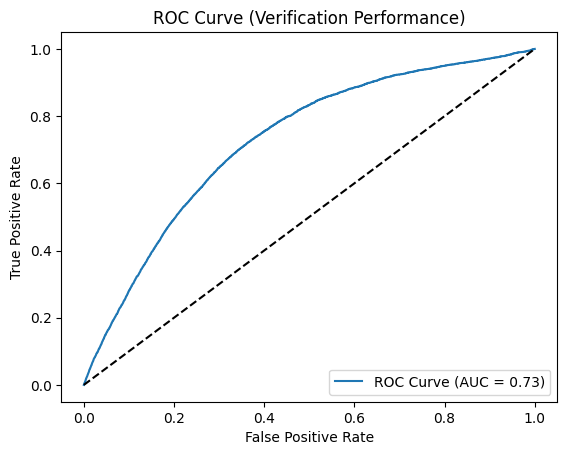

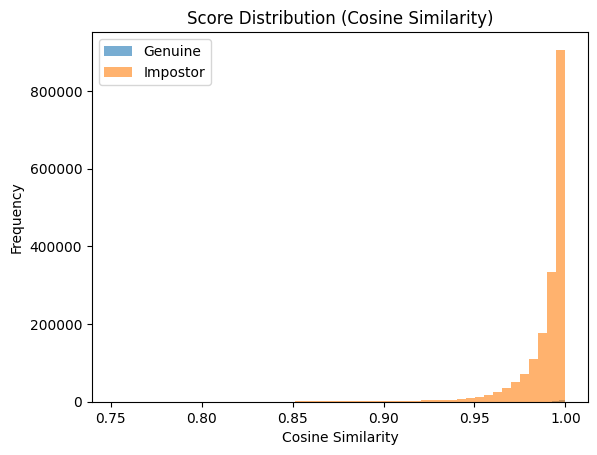

📊 Performance Metrics:
✅ Top-1 Accuracy: 1.45%
✅ Top-5 Accuracy: 6.28%
✅ ROC-AUC: 0.7263
✅ Equal Error Rate (EER): 32.35%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist

# ===============================
# 1️⃣ Load Dataset
# ===============================
csv_path = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\muzzle_features.csv"  # <-- Update this path
df = pd.read_csv(csv_path)

# Encode cattle IDs as numeric labels
le = LabelEncoder()
df['cattle_id'] = le.fit_transform(df['cattle_id'])

# Features and labels
X = df[['num_blobs', 'mean_intensity', 'std_intensity']].values.astype(float)
y = df['cattle_id'].values

# Split into gallery (enrollment) and test set (50/50 split per class)
gallery_features = []
gallery_labels = []
test_features = []
test_labels = []

for label in np.unique(y):
    class_features = X[y == label]
    if len(class_features) < 2:
        continue
    split = len(class_features) // 2
    gallery_features.append(class_features[:split])
    gallery_labels.append([label]*split)
    test_features.append(class_features[split:])
    test_labels.append([label]*(len(class_features)-split))

gallery_features = np.vstack(gallery_features)
gallery_labels = np.hstack(gallery_labels)
test_features = np.vstack(test_features)
test_labels = np.hstack(test_labels)

# ===============================
# 2️⃣ Cosine Similarity Matching
# ===============================
def cosine_similarity(a, b):
    return 1 - cdist(a, b, metric='cosine')

similarity_matrix = cosine_similarity(test_features, gallery_features)

# Top-1 and Top-5 accuracy
top1_correct = 0
top5_correct = 0

for i, true_label in enumerate(test_labels):
    idx_sorted = np.argsort(-similarity_matrix[i])  # highest similarity first
    top1 = gallery_labels[idx_sorted[0]]
    top5 = gallery_labels[idx_sorted[:5]]
    if top1 == true_label:
        top1_correct += 1
    if true_label in top5:
        top5_correct += 1

top1_accuracy = top1_correct / len(test_labels) * 100
top5_accuracy = top5_correct / len(test_labels) * 100

# ===============================
# 3️⃣ ROC-AUC for Verification
# ===============================
genuine_scores = []
impostor_scores = []

for i, true_label in enumerate(test_labels):
    for j, sim in enumerate(similarity_matrix[i]):
        if gallery_labels[j] == true_label:
            genuine_scores.append(sim)
        else:
            impostor_scores.append(sim)

y_true = np.array([1]*len(genuine_scores) + [0]*len(impostor_scores))
y_scores = np.array(genuine_scores + impostor_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Equal Error Rate (EER)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
eer = fpr[np.nanargmin(np.absolute(fnr - fpr))] * 100

# ===============================
# 4️⃣ Confusion Matrix (Top-1)
# ===============================
pred_labels = [gallery_labels[np.argmax(similarity_matrix[i])] for i in range(len(test_labels))]
cm = confusion_matrix(test_labels, pred_labels)

# ===============================
# 5️⃣ Visualization
# ===============================
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Verification Performance)')
plt.legend(loc='lower right')
plt.show()

plt.figure()
plt.hist(genuine_scores, bins=50, alpha=0.6, label='Genuine')
plt.hist(impostor_scores, bins=50, alpha=0.6, label='Impostor')
plt.title('Score Distribution (Cosine Similarity)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# ===============================
# 6️⃣ Final Results
# ===============================
print("📊 Performance Metrics:")
print(f"✅ Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"✅ Top-5 Accuracy: {top5_accuracy:.2f}%")
print(f"✅ ROC-AUC: {roc_auc:.4f}")
print(f"✅ Equal Error Rate (EER): {eer:.2f}%")
